In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
cd /content/drive/MyDrive/'Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


# CÁC PHÉP TĂNG CƯỜNG CHUYÊN SÂU THEO BÀI BÁO


In [5]:
pip install numpy opencv-python albumentations scikit-image ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00


In [6]:
import numpy as np
import cv2
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive

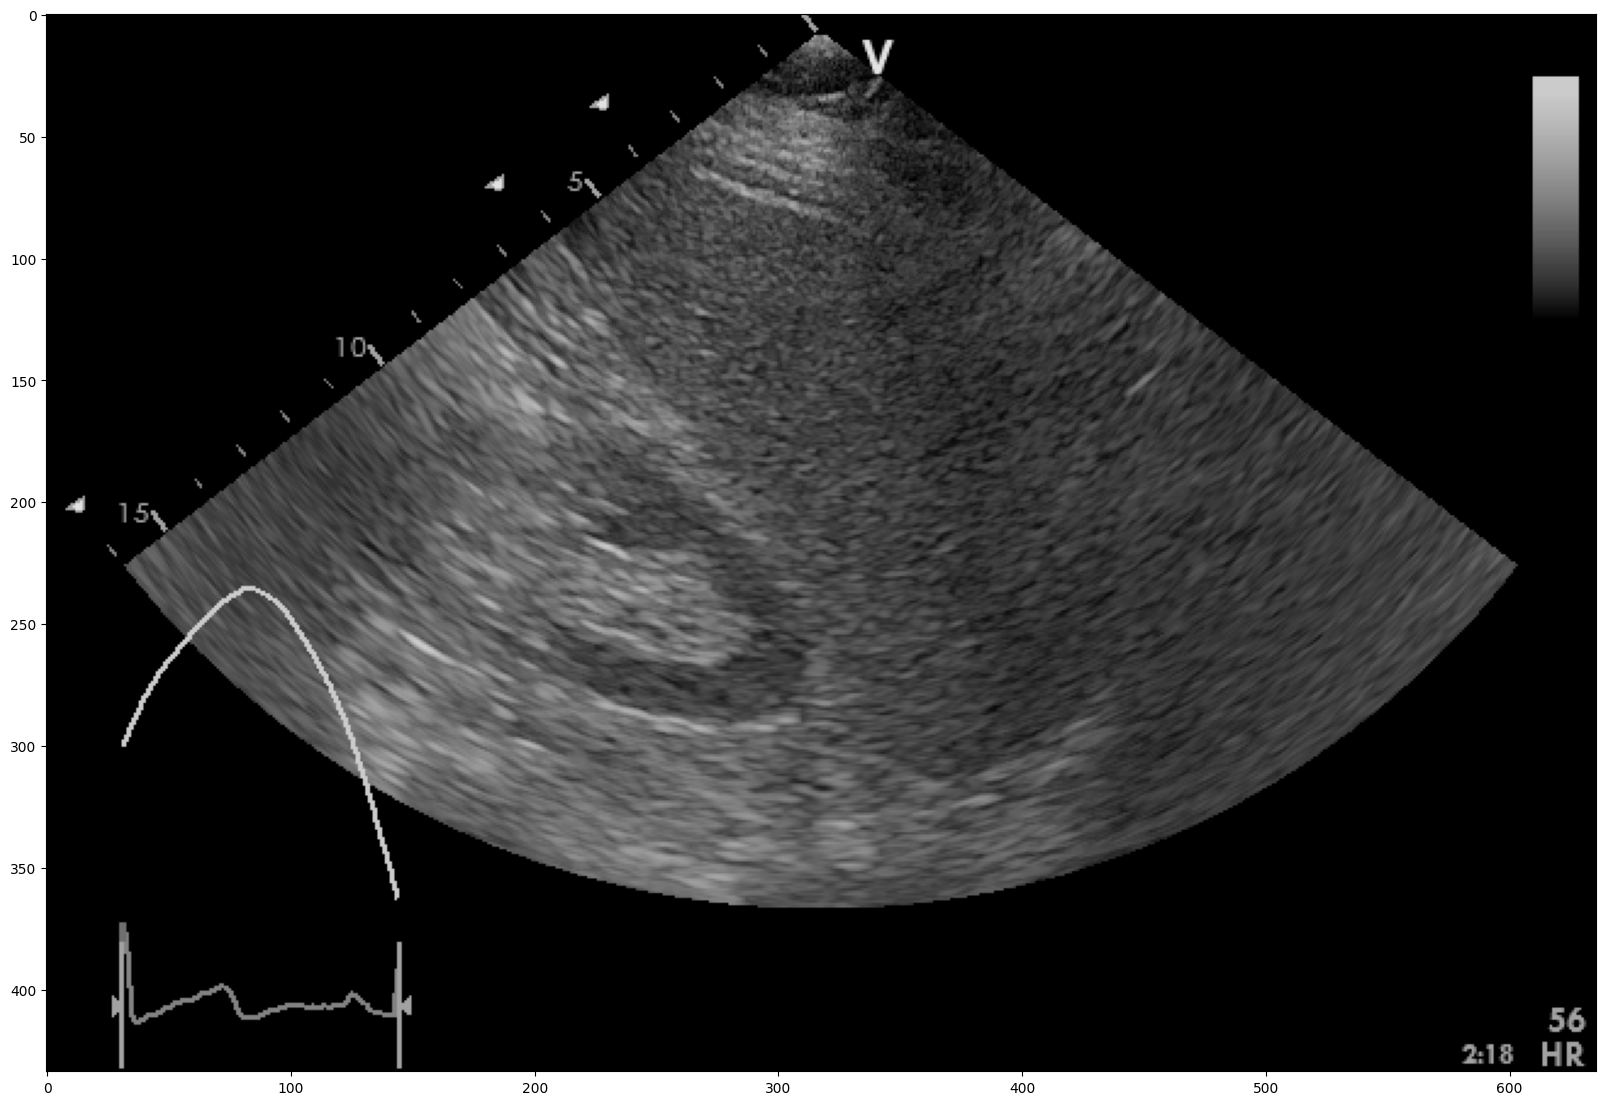

In [8]:
image_path = "/content/drive/MyDrive/Colab Notebooks/byra2018_liver_ultrasound.png"
figAnh= plt.figure(figsize=(20,15))
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

#TĂNG CƯỜNG CHUYÊN SÂU

In [9]:
#hàm tạo mặt nạ ảnh hưởng (hình quạt)
#dựa theo hình quạt cảu hình siêu âm ko có công thức trong bài báo
def create_fan_mask(h, w, center_x=None, center_y=None, theta=np.pi*2/3, max_radius=None, angle_offset=np.pi/2):
    if center_x is None:
        center_x = w / 2
    if center_y is None:
        center_y = 0
    if max_radius is None:
        max_radius = min(h, w) / 2

    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    X = X - center_x
    Y = Y - center_y

    r = np.sqrt(X**2 + Y**2)
    angle = np.arctan2(Y, X) - angle_offset
    angle = np.mod(angle + np.pi, 2*np.pi) - np.pi

    mask = (r <= max_radius) & (np.abs(angle) <= theta / 2)
    return mask.astype(np.float32)

#áp mạt nạ lên ảnh gốc

def overlay_mask_on_image(image, mask, alpha=0.3, color=(0,1,0)):
    image_rgb = np.stack([image]*3, axis=-1)
    mask_rgb = np.zeros_like(image_rgb)
    mask_rgb[:,:,0] = color[0]  #=0
    mask_rgb[:,:,1] = color[1]  #=1
    mask_rgb[:,:,2] = color[2]  #=0
    overlay = (1 - alpha) * image_rgb + alpha * mask_rgb * mask[:,:,None]
    overlay = np.clip(overlay, 0, 1)
    return overlay

#các hàm tăng cường chuyên sâu
 #muy: tỉ lệ suy giảm (attenuation rate µ) set=[0,3),lamda(=0): độ suy giảm tối đa(maximum attenuation λ)

def depth_attenuation(img, mask, muy, lamda):
    h, w = img.shape[:2]
    x = np.linspace(-0.5, 0.5, w)
    y = np.linspace(0, 1, h)
    X, Y = np.meshgrid(x, y)
    d = np.sqrt(X**2 + Y**2)
    attenuation_map = (1 - lamda) * np.exp(-muy * d) + lamda  # công thức tính bản dồ suy giảm
    augmented = img * (mask * attenuation_map + (1 - mask))
    return np.clip(augmented, 0, 1)
#radius(r ∼ U(0.05,0.95)) bán kính r haze , sigma(σ ∼ U(0,0.1)): độ lệch chuẩn, tham số u ∼ U(0,0.1)

def haze_artifact(img, mask, radius, sigma, u):
    h, w = img.shape[:2]
    x = np.linspace(-0.5, 0.5, w)
    y = np.linspace(0, 1, h)
    X, Y = np.meshgrid(x, y)
    d = np.sqrt(X**2 + Y**2)
    haze = 0.5 * u * np.exp(-((d - radius)**2) / (2 * sigma**2))
    augmented = img + mask * haze
    return np.clip(augmented, 0, 1)
 #mu_x,y tâm bonmgs định vị ngẫu nhiên, sigma_x,y kichs thước 0.1-0.4 , strenght độ mạnh bóng 0.25-0.8

def gaussian_shadow(img, mask, strength, sigma_x, sigma_y, mu_x, mu_y):
    h, w = img.shape[:2]
    x = np.linspace(0, 1, w)
    y = np.linspace(0, 1, h)
    X, Y = np.meshgrid(x, y)
    gaussian_shadow = 1 - strength * np.exp(-((X - mu_x)**2 / (2 * (sigma_x**2)) + (Y - mu_y)**2 / (2 * sigma_y**2)))
    augmented = img * (mask * gaussian_shadow + (1 - mask))
    return np.clip(augmented, 0, 1)

def speckle_reduction(img, sigma_spatial, sigma_color):
  #áp dụng bộ lọc hai chiều với các giá trị tham số được lấy mẫu ngẫu nhiên để giảm thiểu ảnh hưởng của các mẫu
    augmented = denoise_bilateral(img, sigma_spatial=sigma_spatial, sigma_color=sigma_color, channel_axis=None)
    # hàm của thư viện thư viện scikit-image (trong bài báo ko nêu rõ )
    return np.clip(augmented, 0, 1)

#hiên thị ảnh và tạo mặt nạ

def load_image_and_fan_mask(image_path, fan_angle=np.pi*2/3, max_radius_factor=0.9, angle_offset=np.pi/2):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Lỗi ảnh {image_path}")

    image = image.astype(np.float32) / 255.0
    h, w = image.shape
    mask = create_fan_mask(h, w, theta=fan_angle, max_radius=h * max_radius_factor, angle_offset=angle_offset)

    return image, mask

#hàm hiển thị

def display_augmentations(theta_deg, radius_factor, angle_offset_deg,
                          muy, lamda,
                          radius, u, sigma_haze,
                          strength, sigma_x, sigma_y, mu_x, mu_y,
                          sigma_spatial, sigma_color):

    theta_rad = np.deg2rad(theta_deg)
    angle_offset_rad = np.deg2rad(angle_offset_deg)
    h, w = image.shape
    mask = create_fan_mask(h, w, theta=theta_rad, max_radius=h * radius_factor, angle_offset=angle_offset_rad)

    fig, axes = plt.subplots(2, 5, figsize=(30, 15))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title("Ảnh gốc")
    axes[0, 0].axis('off')

    #điều chỉnh mặt nạ
    overlay = overlay_mask_on_image(image, mask, alpha=0.3, color=(0,1,0))

    #điều chỉnh độ sâu
    aug1 = depth_attenuation(image, mask, muy, lamda)
    axes[0,1].imshow(aug1, cmap='gray')
    axes[0,1].set_title(f"Depth Attenuation\n muy={muy:.2f},\n lamda={lamda:.2f}")
    axes[0,1].axis('off')

    #điều chỉnh haze
    aug2 = haze_artifact(image, mask, radius, u, sigma_haze)
    axes[0,2].imshow(aug2, cmap='gray')
    axes[0,2].set_title(f"Haze Artifact\nradius={radius:.2f},\n sigma={sigma_haze:.2f},\n Tham số u={u}")
    axes[0,2].axis('off')

    #điều chỉnh bóng gauss
    aug3 = gaussian_shadow(image, mask, strength, sigma_x, sigma_y, mu_x, mu_y)
    axes[0,3].imshow(aug3, cmap='gray')
    axes[0,3].set_title(f"Gaussian Shadow\nstrength={strength:.2f},\n sigma_x={sigma_x}, sigma_y={sigma_y},\n mu_x={mu_x},mu_y={mu_y}")
    axes[0,3].axis('off')

    #điều chỉnh nhiễu speckle
    aug4 = speckle_reduction(image, sigma_spatial, sigma_color)
    axes[0,4].imshow(aug4, cmap='gray')
    axes[0,4].set_title(f"Speckle Reduction\nsigma_spatial={sigma_spatial:.2f},\n sigma_color={sigma_color:.2f}")
    axes[0,4].axis('off')

    #trừ ảnh tìm điểm khác biệt
    def diff_image(diff):
        diff = diff / diff.max() if diff.max() > 0 else diff
        image_rgb = np.stack([image]*3, axis=-1)
        mask_rgb = np.zeros_like(image_rgb)
        mask_rgb[:,:,0] = 1
        alpha = 0.5
        overlay = (1 - diff[:,:,None] * alpha) * image_rgb + (diff[:,:,None] * alpha) * mask_rgb
        return np.clip(overlay, 0, 1)

    axes[1, 0].imshow(overlay)
    axes[1, 0].set_title(f"Mặt nạ\n Góc quét={theta_deg} deg,\n Bán kính={radius_factor:.2f},\n Góc xoay={angle_offset_deg:.1f} deg")
    axes[1, 0].axis('off')

    diff1 = np.abs(image - aug1)
    axes[1, 1].imshow(diff_image(diff1))
    axes[1, 1].set_title("Diff: Depth Attenuation")
    axes[1, 1].axis('off')

    diff2 = np.abs(image - aug2)
    axes[1, 2].imshow(diff_image(diff2))
    axes[1, 2].set_title("Diff: Haze Artifact")
    axes[1, 2].axis('off')

    diff3 = np.abs(image - aug3)
    axes[1, 3].imshow(diff_image(diff3))
    axes[1, 3].set_title("Diff: Gaussian Shadow")
    axes[1, 3].axis('off')

    diff4 = np.abs(image - aug4)
    axes[1, 4].imshow(diff_image(diff4))
    axes[1, 4].set_title("Diff: Speckle Reduction")
    axes[1, 4].axis('off')

    plt.tight_layout()
    plt.show()


#tạo thanh kéo
interactive_plot = interactive(
    display_augmentations,

    #mặt nạ hình quạt
    theta_deg=widgets.FloatSlider(min=30, max=180, step=5, value=120, description="Góc quét"),                       #với ảnh hiện tại 150
    radius_factor=widgets.FloatSlider(min=0.5, max=1.0, step=0.05, value=0.9, description="Bán kính"),
    angle_offset_deg=widgets.FloatSlider(min=-180, max=180, step=5, value=90, description="Góc quay"),

    #suy hao độ sâu
    muy=widgets.FloatSlider(min=0.0, max=3.0, step=0.05, value=1.0, description="Depth-muy"),
    lamda=widgets.FloatSlider(min=0.0, max=1.0, step=0.05, value=0.0,description='Depth-lamda'),

    #hiệu ứng sương mù
    radius=widgets.FloatSlider(min=0.05, max=0.95, step=0.05, value=0.5, description='Haze-radius'),
    u=widgets.FloatSlider(min=0.0, max=0.1, step=0.05, value=0.1, description="Haze-u" ),
    sigma_haze=widgets.FloatSlider(min=0.0, max=0.1, step=0.01, value=0.05, description='Haze-sigma'),

    #đổ bóng gaussian
    strength=widgets.FloatSlider(min=0.25, max=0.8, step=0.05, value=0.5, description='Gauss-strength'),
    sigma_x=widgets.FloatSlider(min=0.01, max=0.2, step=0.01, value=0.1, description='Gauss-sigX' ),
    sigma_y=widgets.FloatSlider(min=0.01, max=0.2, step=0.01, value=0.1, description='Gaus-sigY'),
    mu_x=widgets.FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5,description='Gauss-muX'),
    mu_y=widgets.FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5,description='Gauss-muY'),

    #giảm đốm nhiễu
    sigma_spatial=widgets.FloatSlider(min=0.05, max=2.0, step=0.05, value=0.5,description="Speckle-spatial"),
    sigma_color=widgets.FloatSlider(min=0.05, max=1.0, step=0.05, value=0.5,description='Speckle-color')
    )


# image_path = "/content/1417.jpeg"
image, mask = load_image_and_fan_mask(image_path, fan_angle=np.pi*2/3, max_radius_factor=0.9, angle_offset=np.pi/2)

display(interactive_plot)

interactive(children=(FloatSlider(value=120.0, description='Góc quét', max=180.0, min=30.0, step=5.0), FloatSl…

#TĂNG CƯỜNG TỰ NHIÊN

In [10]:
#các công thức lấy từ nguồn khác
#hàm đièu chỉnh độ sáng (độ lệch delta=(-0.2,0.2))
def brightness(img, delta):
    factor = 1.0 + delta
    return np.clip(img * factor, 0, 1)
#độ tương phản (độ lệch delta=(-0.2,0.2))
def contrast(img, delta):
    factor = 1.0 + delta
    mean = np.mean(img)
    return np.clip((img - mean) * factor + mean, 0, 1)
#độ sáng phi tuyếnh tính
def gamma(img, gamma_value):
    gamma = gamma_value / 100.0
    return np.clip(np.power(img, gamma), 0, 1)
#nhiễu guassian
def gaussian_noise(img, std=0.15, mean=0.0):    #std là độ lệch chuẩn
    noise = np.random.normal(mean, std, img.shape)
    return np.clip(img + noise, 0, 1)
#xoay
def rotate(img, angle):
    h, w = img.shape
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
#dịch chuyển
def translate(img, shift_x_ratio, shift_y_ratio):
    h, w = img.shape
    tx = int(shift_x_ratio * w)
    ty = int(shift_y_ratio * h)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
#phóng to
def zoom(img, scale_delta):
    zoom_factor = 1.0 + scale_delta
    h, w = img.shape
    zh, zw = int(h * zoom_factor), int(w * zoom_factor)
    resized = cv2.resize(img, (zw, zh), interpolation=cv2.INTER_LINEAR)
    if zoom_factor < 1.0:
        pad_h = (h - zh) // 2
        pad_w = (w - zw) // 2
        return np.pad(resized, ((pad_h, h - zh - pad_h), (pad_w, w - zw - pad_w)), mode='empty')
    else:
        crop_h = (zh - h) // 2
        crop_w = (zw - w) // 2
        return resized[crop_h:crop_h+h, crop_w:crop_w+w]

def random_crop(img, crop_h=224, crop_w=224):
    h, w = img.shape
    if h < crop_h or w < crop_w:
        raise ValueError(f"Ảnh quá nhỏ để crop ({crop_h}x{crop_w}). Kích thước hiện tại: {h}x{w}")
    top = np.random.randint(0, h - crop_h + 1)
    left = np.random.randint(0, w - crop_w + 1)
    return img[top:top + crop_h, left:left + crop_w]

def flip_horizontal(img):
    return np.fliplr(img)

def flip_vertical(img):
    return np.flipud(img)

def resize(img, size=224):
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
#hiển thị
def display_all_augmentations(
    brightness_delta, contrast_delta, gamma_value,
    rotate_angle, shift_x, shift_y, scale_delta,
    crop_flag
):
    fig, axes = plt.subplots(3, 4, figsize=(28, 15))
    #ảnh gốc
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title("Ảnh gốc")
    axes[0, 0].axis('off')

    aug1 = brightness(image, brightness_delta)
    axes[0, 1].imshow(aug1, cmap='gray')
    axes[0, 1].set_title(f"Độ sáng\nΔ={brightness_delta:.2f}")
    axes[0, 1].axis('off')

    aug2 = contrast(image, contrast_delta)
    axes[0, 2].imshow(aug2, cmap='gray')
    axes[0, 2].set_title(f"Tương phản\nΔ={contrast_delta:.2f}")
    axes[0, 2].axis('off')

    aug3 = gamma(image, gamma_value)
    axes[0, 3].imshow(aug3, cmap='gray')
    axes[0, 3].set_title(f"Gamma\n{gamma_value}/100")
    axes[0, 3].axis('off')

    aug4 = gaussian_noise(image)
    axes[1, 0].imshow(aug4, cmap='gray')
    axes[1, 0].set_title("Gaussian Noise\nstd=0.15")
    axes[1, 0].axis('off')

    aug5 = rotate(image, rotate_angle)
    axes[1, 1].imshow(aug5, cmap='gray')
    axes[1, 1].set_title(f"Xoay\n{rotate_angle}°")
    axes[1, 1].axis('off')

    aug6 = translate(image, shift_x, shift_y)
    axes[1, 2].imshow(aug6, cmap='gray')
    axes[1, 2].set_title(f"Dịch chuyển theo\nx={shift_x:.4f}, y={shift_y:.4f}")
    axes[1, 2].axis('off')

    aug7 = zoom(image, scale_delta)
    axes[1, 3].imshow(aug7, cmap='gray')
    axes[1, 3].set_title(f"Zoom\nΔ={scale_delta:.2f}")
    axes[1, 3].axis('off')

    if crop_flag == 1:
        try:
            aug8 = random_crop(image, 224, 224)
            axes[2, 0].imshow(aug8, cmap='gray')
            axes[2, 0].set_title("Random Crop\n224×224")
        except ValueError as e:
            axes[2, 0].text(0.5, 0.5, str(e), ha='center', va='center')
            axes[2, 0].set_title("Random Crop\n(Lỗi ảnh nhỏ)")
    else:
        axes[2, 0].axis('off')

    aug9 = flip_horizontal(image)
    axes[2, 1].imshow(aug9, cmap='gray')
    axes[2, 1].set_title("Lật chiều ngang ")
    axes[2, 1].axis('off')

    aug10 = flip_vertical(image)
    axes[2, 2].imshow(aug10, cmap='gray')
    axes[2, 2].set_title("Lật chiều dọc")
    axes[2, 2].axis('off')

    aug11 = resize(image)
    axes[2, 3].imshow(aug11, cmap='gray')
    axes[2, 3].set_title("224×224")
    axes[2, 3].axis('off')

    plt.tight_layout()
    plt.show()

#Load image
# image_path = "/content/1417.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

#slider

interactive_ui = interactive(
    display_all_augmentations,
    brightness_delta=widgets.FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0, description='Δ Brightness'),
    contrast_delta=widgets.FloatSlider(min=-0.2, max=0.2, step=0.01, value=0.0, description='Δ Contrast'),
    gamma_value=widgets.FloatSlider(min=80, max=120, step=1, value=100, description='Gamma ×100'),
    rotate_angle=widgets.FloatSlider(min=-30, max=30, step=1, value=0, description='Rotate (°)'),
    shift_x=widgets.FloatSlider(min=-0.0625, max=0.0625, step=0.005, value=0.0, description='Shift X', readout_format='.4f'),
    shift_y=widgets.FloatSlider(min=-0.0625, max=0.0625, step=0.005, value=0.0, description='Shift Y', readout_format='.4f'),
    scale_delta=widgets.FloatSlider(min=-0.1, max=0.1, step=0.01, value=0.0, description='Zoom Δ'),
    crop_flag=widgets.FloatSlider(min=0, max=1, step=1, value=1, description='Crop')
)
display(interactive_ui)


interactive(children=(FloatSlider(value=0.0, description='Δ Brightness', max=0.2, min=-0.2, step=0.01), FloatS…